In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

# Loading of Fashion Dataset

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [3]:
train_images.shape, train_labels.shape, test_images.shape,test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

### Load the VGG-19 model. Drop after the block4 conv1 layer (highlighted in the image below) and on top of it add one global average pooling layer, one fully connected layer, and one final output layer. Keep the base model layers (VGG19) freeze.

224x224 was causing memory issue on my system so using 48x48 as target size. The shape of the images are changed from 28x28x3 to 48x48x3.This snippet is using the same processing as used by vggnet19 for their preprocessing.

In [6]:
# Define the target size for resizing
target_size = (48, 48)

# Initialize lists to store the resized and expanded images
resized_train_images = []
resized_test_images = []

In [7]:
# Resizing and expanding the training images
for img in train_images:
    resized_img = cv2.resize(img, target_size)
    resized_img = np.repeat(resized_img[..., np.newaxis], 3, -1) # adding rgb channel
    resized_train_images.append(resized_img)

In [8]:
# Resizing and expanding the test images
for img in test_images:
    resized_img = cv2.resize(img, target_size)
    resized_img = np.repeat(resized_img[..., np.newaxis], 3, -1)
    resized_test_images.append(resized_img)

In [9]:
# Converting back the lists to NumPy arrays
resized_train_images = np.array(resized_train_images)
resized_test_images = np.array(resized_test_images)

In [10]:
resized_test_images.shape,resized_train_images.shape

((10000, 48, 48, 3), (60000, 48, 48, 3))

In [11]:
resized_train_images[1][0]

array([[  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  1,   1,   1],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  5,   5,   5],
       [ 29,  29,  29],
       [ 84,  84,  84],
       [170, 170, 170],
       [149, 149, 149],
       [101, 101, 101],
       [ 72,  72,  72],
       [ 52,  52,  52],
       [ 49,  49,  49],
       [ 46,  46,  46],
       [ 43,  43,  43],
       [ 67,  67,  67],
       [ 97,  97,  97],
       [144, 144, 144],
       [158, 158, 158],
       [137, 137, 137],
       [ 79,  79,  79],
       [ 15,  15,  15],
       [  6,   6,   6],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0

To make predictions on new images, I need to preprocess the input images in the same way that the original training images were preprocessed.

In [15]:
# Normalize pixel values to be between 0 and 1
resized_train_images, resized_test_images = resized_train_images / 255.0, resized_test_images / 255.0

In [16]:
resized_train_images.shape, resized_test_images.shape

((60000, 48, 48, 3), (10000, 48, 48, 3))

In [17]:
resized_train_images[1][0]

array([[0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.00392157, 0.00392157, 0.00392157],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.01960784, 0.01960784, 0.01960784],
       [0.11372549, 0.11372549, 0.11372549],
       [0.32941176, 0.32941176, 0.32941176],
       [0.66666667, 0.66666667, 0.66666667],
       [0.58431373, 0.58431373, 0.58431373],
       [0.39607843, 0.39607843, 0.39607843],
       [0.

In [18]:
# Loading the VGG-19 model with pre-trained weights (include_top=False this will not include the top layer)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

In [19]:

for layer in base_model.layers:
    layer.trainable = False # Freezing the base model layers

In [20]:

layer = base_model.get_layer('block4_conv1').output # Dropping after the block4 conv1 layer

In [21]:
# Adding Global Average Pooling layer
layer = GlobalAveragePooling2D()(layer)

In [23]:
# Adding one fully connected layer
layer = Dense(512, activation='relu')(layer)

In [24]:
# Adding one final output layer with the 10 classes
output = Dense(10, activation='softmax')(layer)

In [25]:
# the changed model after adding last few layers
vgg_model = Model(inputs=base_model.input, outputs=output)

In [26]:
# I didn't one-hot encode as is done in the base vggnet19 model, instead using sparse_categorical_crossentropy which does it internally
vgg_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [27]:
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

# Training using the resized fashion train images


In [28]:
history = vgg_model.fit(resized_train_images, train_labels, epochs=10, validation_split=0.2,batch_size=32)

Epoch 1/10
1500/1500 [==============================] - 22s 13ms/step - loss: 1.0553 - accuracy: 0.7504 - val_loss: 0.5002 - val_accuracy: 0.8205
Epoch 2/10
1500/1500 [==============================] - 15s 10ms/step - loss: 0.5065 - accuracy: 0.8182 - val_loss: 0.4894 - val_accuracy: 0.8236
Epoch 3/10
1500/1500 [==============================] - 18s 12ms/step - loss: 0.4599 - accuracy: 0.8331 - val_loss: 0.4150 - val_accuracy: 0.8519
Epoch 4/10
1500/1500 [==============================] - 15s 10ms/step - loss: 0.4332 - accuracy: 0.8436 - val_loss: 0.3898 - val_accuracy: 0.8577
Epoch 5/10
1500/1500 [==============================] - 15s 10ms/step - loss: 0.4033 - accuracy: 0.8519 - val_loss: 0.4208 - val_accuracy: 0.8460
Epoch 6/10
1500/1500 [==============================] - 15s 10ms/step - loss: 0.3938 - accuracy: 0.8581 - val_loss: 0.3681 - val_accuracy: 0.8704
Epoch 7/10
1500/1500 [==============================] - 15s 10ms/step - loss: 0.3805 - accuracy: 0.8634 - val_loss: 0.4391 -

In [29]:
test_loss_vgg, test_accuracy_vgg = vgg_model.evaluate(resized_test_images, test_labels, verbose=0)

In [30]:
print("Test Accuracy of modified pre-trained VGG using Transfer learning is:", test_accuracy_vgg)

Test Accuracy of modified pre-trained VGG using Transfer learning is: 0.8447999954223633


Text(0, 0.5, 'Loss')

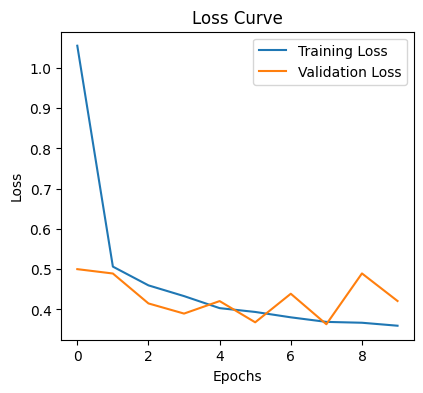

In [31]:
# Plot the learning curve
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')

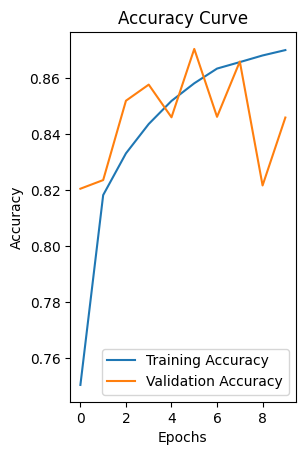

In [32]:
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()